In [ ]:
!pip install -q rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 21.4 MB/s eta 0:00:00


In [22]:
import tensorflow as tf
from keras import models, layers
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

In [23]:
class GraphGenerator_test(tf.keras.Model):
  def __init__(self, num_nodes, node_features, latent_dim, num_bond_types = 5):
     super().__init__()

     self.num_nodes = num_nodes
     self.num_bond_types = num_bond_types
     self.node_features = node_features
     self.latent_dim = latent_dim

     self.base = models.Sequential([
        layers.Dense(128, input_shape = (latent_dim,), activation="leaky_relu"),
        layers.Dense(256, activation = "leaky_relu"),
     ])

     self.adj_head = layers.Dense(num_nodes * num_nodes * num_bond_types, activation = None)
     self.node_head = layers.Dense(num_nodes * node_features, activation = None)

     self.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

  def call(self, z, t = 1.0):
    batch_size = tf.shape(z)[0]

    base_output = self.base(z)

    adj_logits = self.adj_head(base_output)
    adj_logits = tf.reshape(adj_logits, (batch_size, self.num_nodes, self.num_nodes, self.num_bond_types))
    adj_logits_sym = (adj_logits + tf.transpose(adj_logits, perm = [0, 2, 1, 3])) / 2
    adj_probs = tf.nn.softmax(adj_logits_sym / t, axis = -1)

    bond_type_indices = tf.argmax(adj_probs, axis = -1)
    adj_one_hot = tf.one_hot(bond_type_indices, depth = self.num_bond_types)

    node_feature_flat = self.node_head(base_output)
    node_feature_flat = tf.reshape(node_feature_flat, (batch_size, self.num_nodes, self.node_features))
    node_probs = tf.nn.softmax(node_feature_flat, axis = -1)
    node_indices = tf.argmax(node_probs, axis = -1)
    valid_atom_types = tf.constant([1, 6, 7, 8, 9], dtype = tf.int64)
    node_types = tf.gather(valid_atom_types, node_indices)
    node_types = tf.cast(node_types, tf.float32)

    return adj_one_hot, node_types

  def loss_function(self, real_output, fake_output):
    loss_func = tf.keras.losses.BinaryCrossentropy(from_logits = False)
    return loss_func(real_output, fake_output)

  def fit(self, data, discriminator, epochs = 10):
    for epoch in range(epochs):
      total_loss = 0
      num_batches = 0
      for z in data:
        with tf.GradientTape() as tape:
          gen_adj, gen_z = self(z)

          fake_output = discriminator(gen_adj, gen_z)
          loss = self.loss_function(tf.ones_like(fake_output), fake_output)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        total_loss += loss
        num_batches += 1
      average_loss = total_loss / num_batches
      print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss.numpy():.4f}")

In [24]:
def adjacency_matrix_to_mol(inp_matrix):
  mol = Chem.RWMol()
  atom_types = np.unique(inp_matrix[1])
  matrix = inp_matrix[0]
  atom_map = {i: mol.AddAtom(Chem.Atom(int(atom_types[i]))) for i in range(len(atom_types))}

  if isinstance(matrix, tf.Tensor):
        matrix = matrix.numpy()
  if isinstance(atom_types, tf.Tensor):
      atom_types = atom_types.numpy()

  matrix = np.array(matrix)
  atom_types = np.array(atom_types)

  if len(matrix) != len(atom_types):
    raise ValueError("NUMBER OF ATOM TYPES DOES NOT MATCH MATRIX DIMENSIONS")

  # Step 1: Add Atoms
  for i, atom_num in enumerate(atom_types):
    atom = Chem.Atom(int(atom_num))
    mol_idx = mol.AddAtom(atom)
    atom_map[i] = mol_idx

  # Step 2: Add Bonds
  for i in range(len(matrix)):
    for j in range(i + 1, len(matrix)):
        if j not in atom_map:
            continue

        value = int(np.argmax(matrix[i, j]))
        value = min(max(value, 0), 4)

        if value != 0:
            bond_type = {
                1: Chem.BondType.SINGLE,
                2: Chem.BondType.DOUBLE,
                3: Chem.BondType.TRIPLE,
                4: Chem.BondType.AROMATIC
            }.get(value, None)

            if bond_type is None:
                raise ValueError(f"INVALID BOND TYPE DETECTED: {value}")

            print(f"Adding bond: {i}-{j} Type: {bond_type}")
            mol.AddBond(atom_map[i], atom_map[j], bond_type)

  return mol

In [40]:
gen = GraphGenerator_test(10,5,32)
z = tf.random.normal((5, 32))
gen_out = gen(z)

In [41]:
mol = adjacency_matrix_to_mol(gen_out)

Adding bond: 0-2 Type: TRIPLE
Adding bond: 0-3 Type: AROMATIC
Adding bond: 0-4 Type: SINGLE
Adding bond: 1-2 Type: DOUBLE
Adding bond: 1-4 Type: SINGLE
Adding bond: 2-4 Type: SINGLE
Adding bond: 3-4 Type: SINGLE


In [43]:
smile = Chem.MolToSmiles(mol)

In [44]:
print(smile)

C.C1=N2#[H]3oF132.F.N.O.[HH]


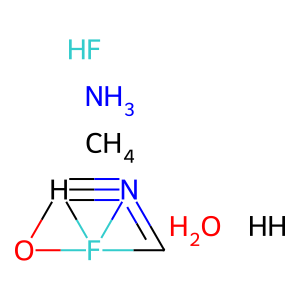

In [42]:
Draw.MolToImage(mol)